## LDA Topic Modeling

Topic modelling is a technique to extract hidden topics from large volume of text. LDA represents topics as word probabilities and allows for uncovering hidden topics as it clusters words based ontheir co-occurrence in a respective document.

### Assumptions for LDA
1. Documents with similar topics use similar groups of words
2. Latent topics can be found by searching for groups of words that frequently occur together in documents across corpus
3. Documents are probability distributions over latent topics that signifies certain document will contain more words of specific topic
4. Topics themselves are probability distribution over words

### Goal: To find out what users speak about

One can use any vectorizer and not just count vectorizer e.g. tfidf - experiment!

### Steps that we will follow are below:
1. Get the data
2. Data cleaning
3. Get the tokens
4. 

In [218]:
# Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 150)

In [219]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions  # from https://github.com/kootenpv/contractions
import string


In [220]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")  # Drop dupes in Reviews
data_in.drop(["Time_submitted", "Total_thumbsup",
             "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data_in.drop(["Length"], axis=1, inplace=True)
data = data_in
data.head(10)

,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,3
6,I love the selection and the lyrics are provided with the song you're listening to!,5
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done N...",3
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despi...",5
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consu...",1


### Clean data

In [221]:
## Define a function to do some text cleaning
def clean_text(text):
    text = emoji.demojize(text)  # fix emojis
    text = contractions.fix(text)  # fix contractions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove strange fonts
    text = re.sub(r"\d+", "number", text)  # replace numbers with "number"
    text = re.sub(r'[^\w\s]', '', text)  # remove non-alphanumeric chars
    text = re.sub(r'\b\w{1}\b', '', text) # remove words less than 3 characters
    text = text.replace('_', ' ')  # replace underscores with space
    text = text.strip()  # strip extra spaces
    return text.lower()

In [222]:
## Test our text cleaner
clean_text("I ❤️ Spotify, even though it is critizised for exploiting artists")

'red heart spotify even though it is critizised for exploiting artists'

In [223]:
## Apply to all data
data["Review"] = data["Review"].apply(clean_text)

In [224]:
## Tokenize/remove punctuations
tokenizer = RegexpTokenizer(r'\w+')

In [225]:
data["Tokens"] = data["Review"].apply(tokenizer.tokenize)

In [226]:
data.sample(10)

,Review,Rating,Tokens
32202,quite good application enjoy the wide variety of music,5,"[quite, good, application, enjoy, the, wide, variety, of, music]"
19109,paid for premium number times and still had the ads,2,"[paid, for, premium, number, times, and, still, had, the, ads]"
55830,there are lot of ads am at the position of deleting this app otherwise it is ok,1,"[there, are, lot, of, ads, am, at, the, position, of, deleting, this, app, otherwise, it, is, ok]"
50304,best app everrrrr cannot believe how much music have been introduced to through their recommendations based on music already like ilove that you...,5,"[best, app, everrrrr, cannot, believe, how, much, music, have, been, introduced, to, through, their, recommendations, based, on, music, already, l..."
38821,spotify is great app for listening music the best but podcasts oh man it terrible yeah it got ton of exclusive podcasts but podcast section of ap...,3,"[spotify, is, great, app, for, listening, music, the, best, but, podcasts, oh, man, it, terrible, yeah, it, got, ton, of, exclusive, podcasts, but..."
48158,new for some months had problem accessing what have downloaded after two weeks it is automatically deleted without my permission forced to redow...,4,"[new, for, some, months, had, problem, accessing, what, have, downloaded, after, two, weeks, it, is, automatically, deleted, without, my, permissi..."
26874,great device brilliant acsess to the music like,5,"[great, device, brilliant, acsess, to, the, music, like]"
60056,this streaming service is very laggy and it is so hard to listen to even single number minute song without it taking number minutes to play til t...,5,"[this, streaming, service, is, very, laggy, and, it, is, so, hard, to, listen, to, even, single, number, minute, song, without, it, taking, number..."
55922,clear crisp audio with uninterrupted number minute play,5,"[clear, crisp, audio, with, uninterrupted, number, minute, play]"
4765,had to switch accounts due to mistake now after logged out the app will not even load have done everything possible number times over nothing ...,1,"[had, to, switch, accounts, due, to, mistake, now, after, logged, out, the, app, will, not, even, load, have, done, everything, possible, number, ..."


In [227]:
# Get NLTK English stopwords
our_stopwords = set(stopwords.words('english'))
additional_stopwords = ["spotify", "app", "apps", "cannot", "like", "love", "much", "many"]
for word in additional_stopwords:
    our_stopwords.add(word)
#our_stopwords.remove("not")
# Remove stopwords
# We loop through each list of words and remove stopwords
data['Tokens'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.sample(5)

,Review,Rating,Tokens
41127,it is so easy to use and find it more convenient when want to listen to particular artist like there is always playlist on spotify for each ar...,5,"[easy, use, find, convenient, want, listen, particular, artist, always, playlist, artist]"
57087,your new updates are terrible cannot do this garbage if it does not change will no longer be paying costumer like how do you rewind or fast for...,1,"[new, updates, terrible, garbage, change, longer, paying, costumer, rewind, fast, forward, even, skip, songs, stop, god, sakes, stop]"
22193,genremood filter not working plays all my songs regardless of the genre choose,2,"[genremood, filter, working, plays, songs, regardless, genre, choose]"
49023,love the app but recently cannot go to premium everytime want to activate premium its always failed to connect somehow you always plays ad to go...,2,"[recently, go, premium, everytime, want, activate, premium, always, failed, connect, somehow, always, plays, ad, go, premium, always, allowed]"
12154,this is more bag because play music is others music play plss respond,2,"[bag, play, music, others, music, play, plss, respond]"


In [228]:
## Split data in train and test
X_train, X_test = train_test_split(data['Tokens'], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(46009,) (15337,)


In [229]:
## Count Vectorizer
def dummy(doc):
    return doc

count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features = 10000, ngram_range = (1,3))

X_train_counts = count_vectorizer.fit_transform(X_train)

In [230]:
## make TFIDF matrix
tfidf_vectorizer = TfidfTransformer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_counts)

In [231]:
## Get number of features from vectorizer and it shall match number of features that we provide to it
len(count_vectorizer.get_feature_names())

10000

In [232]:
## Fit model
LDA = LatentDirichletAllocation(n_components=4,random_state=42)
LDA.fit(X_train_tfidf)

LatentDirichletAllocation(n_components=4, random_state=42)

In [233]:
## Number of components (=topics)
n_components = len(LDA.components_)
print("Number of components: ", n_components)

Number of components:  4


In [239]:
#
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names()[index] for index in (-topic).argsort()[:15]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['playing', 'update', 'phone', 'music', 'play', 'stop', 'fix', 'work', 'number', 'time', 'keeps', 'last', 'even', 'working', 'bar']


THE TOP 15 WORDS FOR TOPIC #1
['music', 'songs', 'listen', 'best', 'great', 'good', 'use', 'playlist', 'premium', 'easy', 'want', 'number', 'would', 'best music', 'free']


THE TOP 15 WORDS FOR TOPIC #2
['song', 'play', 'songs', 'fix', 'please', 'every', 'face', 'number', 'want', 'problem', 'lyrics', 'play song', 'internet', 'even', 'please fix']


THE TOP 15 WORDS FOR TOPIC #3
['ads', 'music', 'good', 'number', 'songs', 'listening', 'face', 'great', 'smiling', 'nice', 'ad', 'favorite', 'listen', 'podcasts', 'adds']




In [240]:
## Let's give a descriptive name to the topics
lda_topics = ['fix_update_phone', 'spotify_is_awesome', 'please_fix_something', 'ads_and_premium']

In [243]:
def get_model_topics(model, vectorizer, topics, n_top_words=10):    
    word_dict = {}    
    feature_names = vectorizer.get_feature_names()    
    for topic_idx, topic in enumerate(model.components_):        
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]        
        top_features = [feature_names[i] for i in top_features_ind]        
        word_dict[topics[topic_idx]] = top_features
    return pd.DataFrame(word_dict)

In [244]:
get_model_topics(LDA, count_vectorizer, lda_topics)

,fix_update_phone,spotify_is_awesome,please_fix_something,ads_and_premium
0,playing,music,song,ads
1,update,songs,play,music
2,phone,listen,songs,good
3,music,best,fix,number
4,play,great,please,songs
5,stop,good,every,listening
6,fix,use,face,face
7,work,playlist,number,great
8,number,premium,want,smiling
9,time,easy,problem,nice


In [245]:
topic_results = LDA.transform(X_train_tfidf)

In [246]:
# Split original data
data_train, _ = train_test_split(data, test_size=0.25, random_state=42)

In [260]:
pd.set_option('display.max_colwidth', 150)
data_train['Topic_number'] = topic_results.argmax(axis=1)
data_train[["Review", "Topic_number"]].sample(10)

,Review,Topic_number
24184,love the app been useing it for maybe few months maybe like number do not know but love it found song love sad cannot repeat it anymore but s...,1
15907,all the music you want just the playlists you need content increases daily,1
42352,been enjoyingloving premium for about year have used other streaming services namely ytm and have no idea what took me so long to try spotify w...,1
19795,it is nice but the only problem that have is that when play song from my favorite selection it will play my favorite songs but wonce there done ...,2
46762,it kicked me out of my account and now it does not let me log in never changed anything nor did forget my info all it says is error when putting ...,3
18586,with the new update my search box is broken music does not play anymore all my likeddownloaded music was deleted and the app is pretty much comple...,0
30565,being able to download podcasts and listen when am in the middle of nowhere is life saver spotty wifis got nothing on spotify face with tears of...,2
57033,probably the best app to listen to music on songs hardly ever take time lodaing and almost any music you can think of can be found there the ads g...,1
48851,love this app like listening to music while fall asleep and this helps me lot,1
34674,something going on with the app used to work great but now the player display has gone so cannot pause and have to restart my phone to stop palyin...,0


In [67]:
LDA.perplexity(X_train_counts)

1724.032346537392

In [68]:
LDA.score(X_train_counts)

-7863772.507264096

In [267]:
def assign_topic_name(topic_number):
    if topic_number == 0:
        return lda_topics[0]
    if topic_number == 1:
        return lda_topics[1]
    if topic_number == 2:
        return lda_topics[2]
    if topic_number == 3:
        return lda_topics[3]
    if topic_number == 4:
        return lda_topics[4]


data_train["Topic_name"] = data_train["Topic_number"].apply(assign_topic_name)

In [268]:
data_train.sample(10)

,Review,Rating,Tokens,Topic,Topic_number,Topic_name
55388,am having issues ensuring my songs stay downloaded to the sd card android user this seems to happen with each update so you are telling me that n...,2,"[issues, ensuring, songs, stay, downloaded, sd, card, android, user, seems, happen, update, telling, uninstall, install, time, make, sure, downloa...",0,0,fix_update_phone
11881,do not want to write but get number ads and then that number mins free one it is ok but today this study app shows me number ads and that number...,1,"[want, write, get, number, ads, number, mins, free, one, ok, today, study, shows, number, ads, number, min, free, one, glitch, something, understa...",3,3,ads_and_premium
11131,your app is constantly stopping love spotify but it is enough to make me stop using it,1,"[constantly, stopping, enough, make, stop, using]",0,0,fix_update_phone
31476,pay for premium also be so kind and fix the glitches,4,"[pay, premium, also, kind, fix, glitches]",1,1,spotify_is_awesome
35924,the spotify session feature is trash there are lot of glitches and cannot listen to my local files also now they are unliking my songs somehow,1,"[session, feature, trash, lot, glitches, listen, local, files, also, unliking, songs, somehow]",0,0,fix_update_phone
3336,brilliant ap have the paid for version the free one is difficult to use as the songs do not play in order but the paid for ap is fantastic,5,"[brilliant, ap, paid, version, free, one, difficult, use, songs, play, order, paid, ap, fantastic]",1,1,spotify_is_awesome
14285,would like dislike button so can tell the app not to place that song in my randomized lists again besides that this is the best music app,4,"[would, dislike, button, tell, place, song, randomized, lists, besides, best, music]",1,1,spotify_is_awesome
11903,is fast but the playlist update is the problem,3,"[fast, playlist, update, problem]",0,0,fix_update_phone
13555,best music apps out their that they should pay us for listening to music on it it is that good,5,"[best, music, pay, us, listening, music, good]",1,1,spotify_is_awesome
22885,it was great app until they decided to squeeze the play and skip buttons as far left as possible there was nothing wrong with the old balanced de...,2,"[great, decided, squeeze, play, skip, buttons, far, left, possible, nothing, wrong, old, balanced, design, right, handed, large, phone, impractica...",0,0,fix_update_phone


In [280]:
topic_f = pd.DataFrame(data_train["Topic_name"].value_counts()).reset_index()
topic_f.columns = ["Topic_name", "Count"]
topic_f

,Topic_name,Count
0,spotify_is_awesome,19686
1,fix_update_phone,13709
2,ads_and_premium,6390
3,please_fix_something,6224


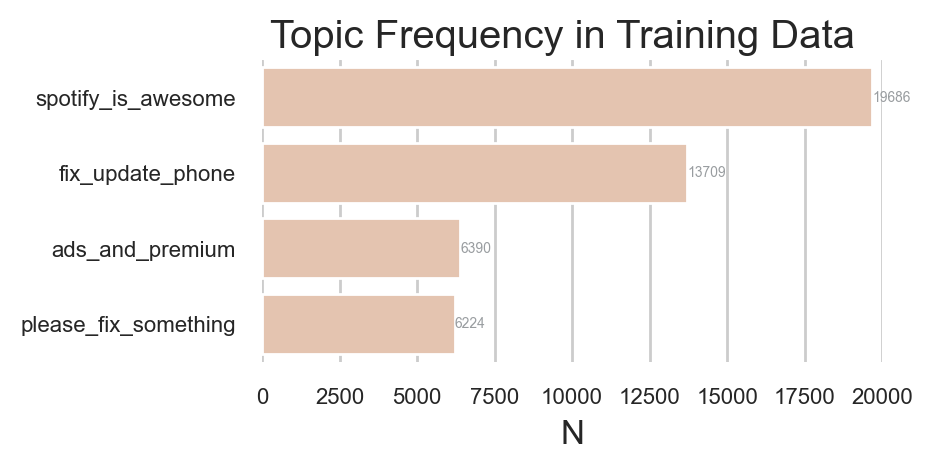

In [287]:
## Plot per country
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(4,2),dpi=200)

sns.set_color_codes("pastel")
sns.barplot(x="Count", 
            y="Topic_name", 
            data=topic_f,
            color = "#EDC2A7")

ax.set(xlim=(0, 20000), ylabel="",
       xlabel="N")
ax.bar_label(ax.containers[0], size=5, label_type="edge", padding=0, color="#999DA0")
plt.suptitle("Topic Frequency in Training Data")

ax.tick_params(labelsize=8)

sns.despine(left=True, bottom=True)

In [19]:
# # Fit model
# perplexities = []
# scores = []
# for n_topic in range(2,40,5):
#     LDA = LatentDirichletAllocation(n_components=n_topic,random_state=42)
#     LDA.fit(X_train_counts)

#     perplexities.append(LDA.perplexity(X_train_counts))
#     scores.append(LDA.score(X_train_counts))

In [20]:
# perplexities

[1873.4875890604776,
 1604.864441814075,
 1586.136041368198,
 1561.2975854831523,
 1582.0079032887143,
 1585.4526173839465,
 1617.617934997826,
 1620.5224290464132]

In [21]:
# scores

[-7951497.133128195,
 -7788192.290062701,
 -7775805.968601594,
 -7759151.124461923,
 -7773056.09267523,
 -7775351.214201408,
 -7796544.557933093,
 -7798437.505047149]

In [ ]:
## To-Do
# Topic and its visualization against word
# Check against test data
# Coherence measure
# Think of considering app as stopword as its present in almost all topics
# Make use of time column from data and see how topic changes over time